In [216]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation
from pymc_marketing.mmm import MMM, GeometricAdstock, LogisticSaturation
from pymc_marketing.prior import Prior
from sklearn.preprocessing import MinMaxScaler
import pymc as pm
import arviz as az

warnings.filterwarnings("ignore",category=FutureWarning)

## Data

In [50]:
data = pd.read_csv("../data/data1.csv",delimiter=',')

###  Data description

In [51]:
print(data.head())
print(data.columns)
print(data.shape)
print(data.dtypes)

        Date   TikTok  Facebook  Google Ads     Sales
0   1/7/2018  13528.1      0.00        0.00   9779.80
1  1/14/2018      0.0   5349.65     2218.93  13245.19
2  1/21/2018      0.0   4235.86     2046.96  12022.66
3  1/28/2018      0.0   3562.21        0.00   8846.95
4   2/4/2018      0.0      0.00     2187.29   9797.07
Index(['Date', 'TikTok', 'Facebook', 'Google Ads', 'Sales'], dtype='object')
(200, 5)
Date           object
TikTok        float64
Facebook      float64
Google Ads    float64
Sales         float64
dtype: object


### Validating data

It is important to understand what we have in the data. These are some initial check-list one can do for sanity check of the data
1. Null count
2. Duplicates
3. Negative value count
   

In [52]:
print("Null count\n",data.isnull().sum())
print("Duplicate count\n",data.duplicated().sum())
print("Negative value count\n",(data.drop(columns=['Date'])<0).sum())

Null count
 Date          0
TikTok        0
Facebook      0
Google Ads    0
Sales         0
dtype: int64
Duplicate count
 0
Negative value count
 TikTok        0
Facebook      0
Google Ads    0
Sales         0
dtype: int64


In [53]:
media_columns = ['TikTok','Facebook','Google Ads']
data['Date'] = pd.to_datetime(data['Date'])
# data.set_index('Date', inplace=True)

### Data visualisation

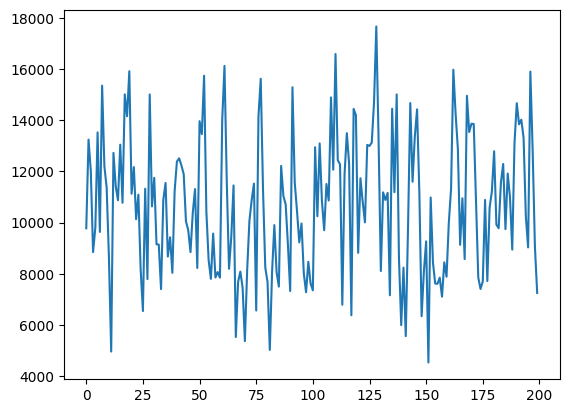

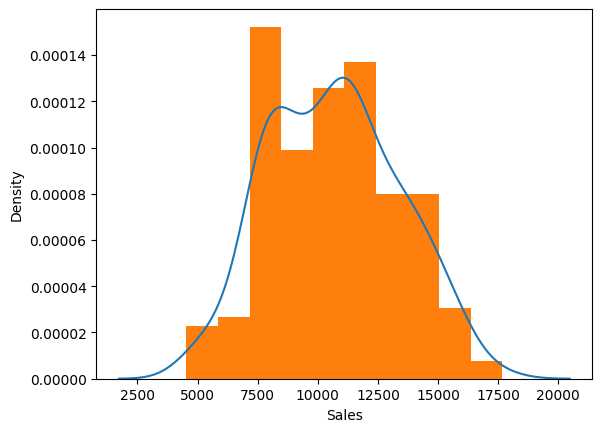

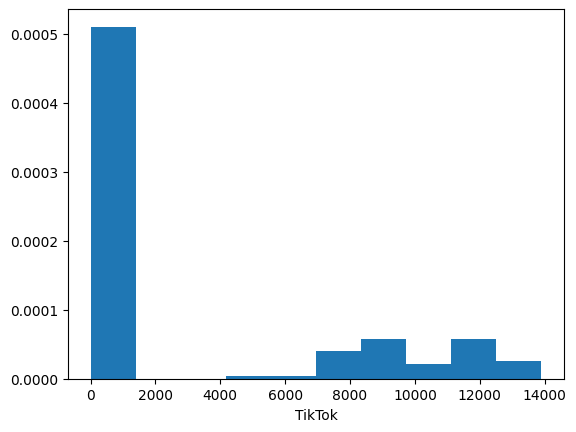

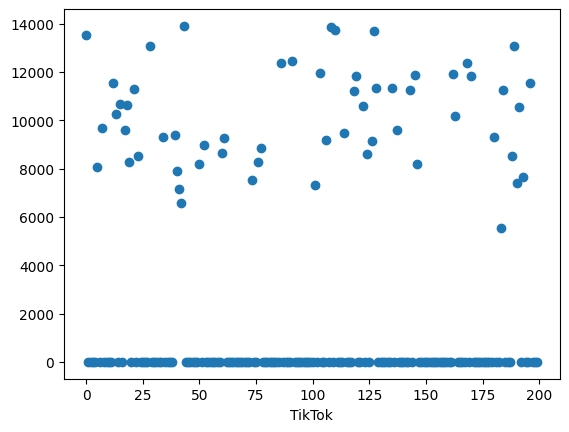

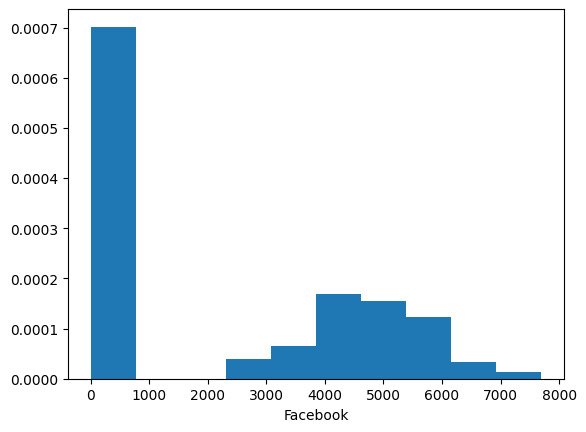

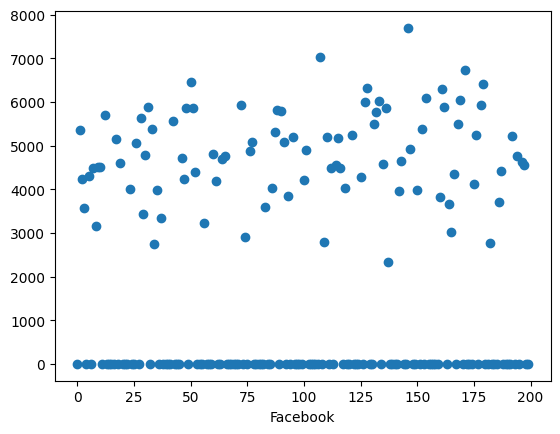

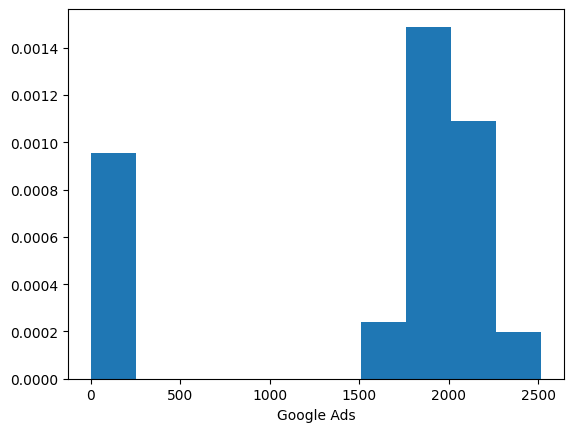

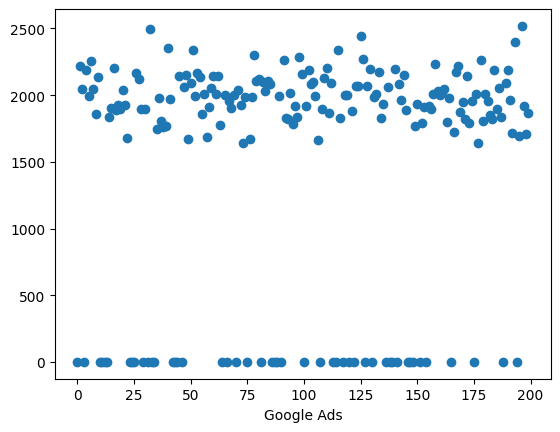

In [54]:
data['Sales'].plot(kind='line')
plt.show()
sns.kdeplot(data['Sales'])
plt.hist(data['Sales'],density=True)
plt.show()
for col in media_columns:
    plt.hist(data[col],density=True)
    plt.xlabel(col)
    # sns.kdeplot(data[col],clip=(0,data[col].max()));
    plt.show()
    plt.scatter(data.index,data[col])
    plt.xlabel(col)
    plt.show()


In [56]:
data.drop("Date",axis=1).corr()

,TikTok,Facebook,Google Ads,Sales
TikTok,1.000000,0.084128,0.021735,0.679205
Facebook,0.084128,1.000000,-0.100946,0.466762
Google Ads,0.021735,-0.100946,1.000000,0.360046
Sales,0.679205,0.466762,0.360046,1.000000


<AxesSubplot: >

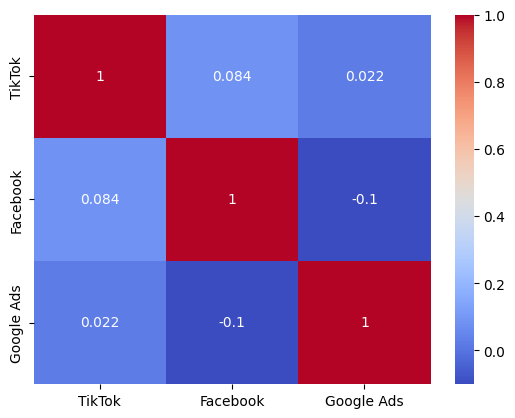

In [57]:
sns.heatmap(data[media_columns].corr(),annot=True,cmap='coolwarm')

## Modeling



In [112]:
scalar = MinMaxScaler()

X_data = data[media_columns]
Y_data = data['Sales']

data_scaled = pd.DataFrame(scalar.fit_transform(data.drop(columns='Date')),columns=media_columns+ ['Sales'])
data_scaled


,TikTok,Facebook,Google Ads,Sales
0,0.973136,0.000000,0.000000,0.399472
1,0.000000,0.695101,0.880919,0.663281
2,0.000000,0.550382,0.812647,0.570213
3,0.000000,0.462852,0.000000,0.328457
4,0.000000,0.000000,0.868358,0.400787
...,...,...,...,...
195,0.000000,0.000000,0.671600,0.342405
196,0.830381,0.599690,1.000000,0.865695
197,0.000000,0.592000,0.761922,0.632381
198,0.000000,0.000000,0.677940,0.344939


### Using Pymc

In [135]:
test_data = 8 

train_idx = slice(0,len(data)-test_data)
test_idx = slice(len(data)-test_data,len(data))

X_data = data_scaled[media_columns]
Y_data = data_scaled['Sales']

Lets model the sales from 3 channels using pymc Model.
We consideration 2 effects while modeling:
1. Adstock : the cumulative effect of spending from the past
2. Saturation : DIminishing returns on spending after a point

In [136]:
n_channels = len(media_columns)
with pm.Model() as pymc_model:

    X = pm.Data("X",X_data.iloc[train_idx].values)
    Y = pm.Data("Y",Y_data.iloc[train_idx].values)
    alpha = pm.Beta("alpha",alpha=3,beta=3,shape = n_channels)
    lam = pm.HalfNormal("lam",sigma=1,shape=n_channels)
    # beta = pm.Beta("beta",alpha=2,beta=2,shape = n_channels)

    X_adstock = geometric_adstock(X,alpha=alpha)
    X_trans = logistic_saturation(X_adstock,lam=lam)

    coeff = pm.HalfNormal("coeff",sigma=1,shape=n_channels)
    intercept = pm.Normal("intercept", mu=5000, sigma=2000)
    mu = pm.Deterministic('mu',intercept+pm.math.dot(X_trans,coeff))

    sigma = pm.HalfNormal("sigma",sigma=1)
    y_obs = pm.Normal("y_obs",mu=mu,sigma=sigma,observed=Y)

    idata_pymc = pm.sample( return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, lam, coeff, intercept, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 302 seconds.


array([[<AxesSubplot: title={'center': 'alpha'}>,
        <AxesSubplot: title={'center': 'alpha'}>],
       [<AxesSubplot: title={'center': 'lam'}>,
        <AxesSubplot: title={'center': 'lam'}>],
       [<AxesSubplot: title={'center': 'coeff'}>,
        <AxesSubplot: title={'center': 'coeff'}>],
       [<AxesSubplot: title={'center': 'intercept'}>,
        <AxesSubplot: title={'center': 'intercept'}>]], dtype=object)

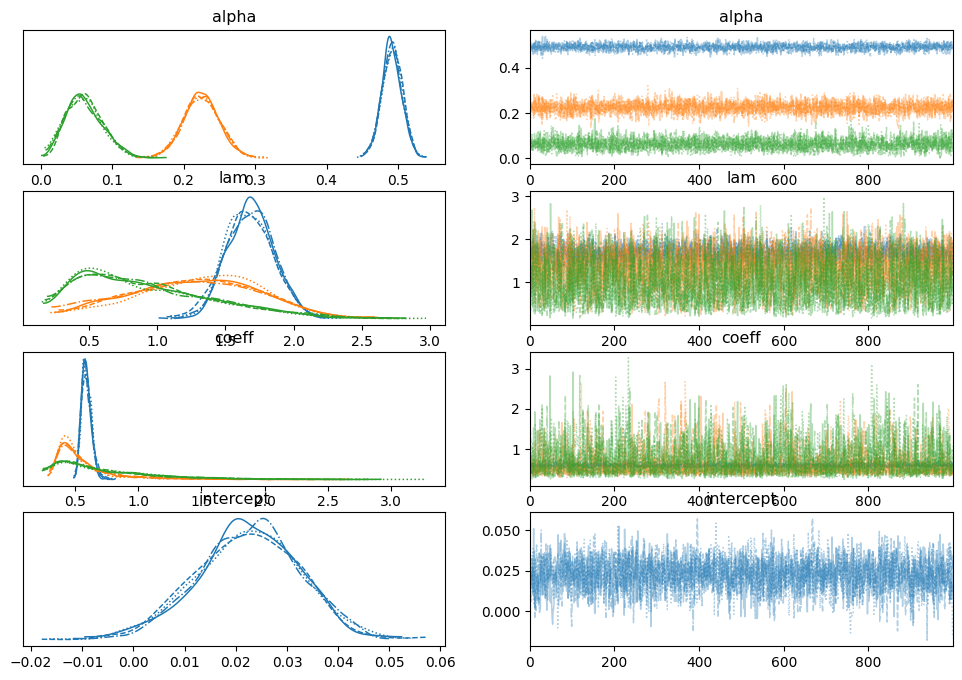

In [137]:
az.plot_trace(idata_pymc, var_names = ["alpha","lam","coeff","intercept"])

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

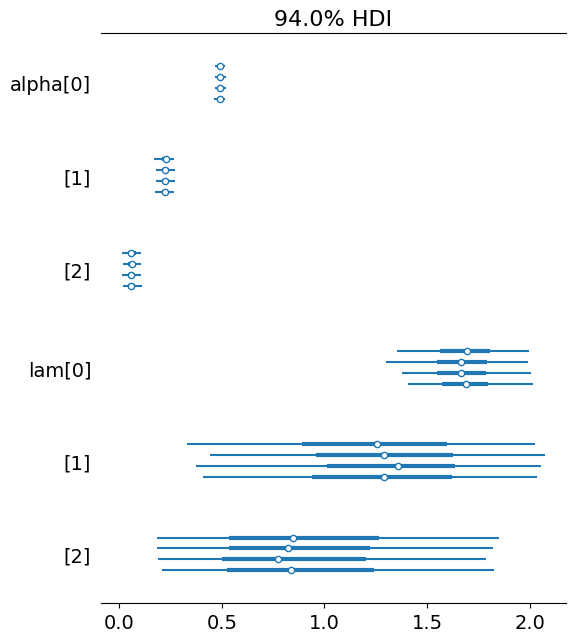

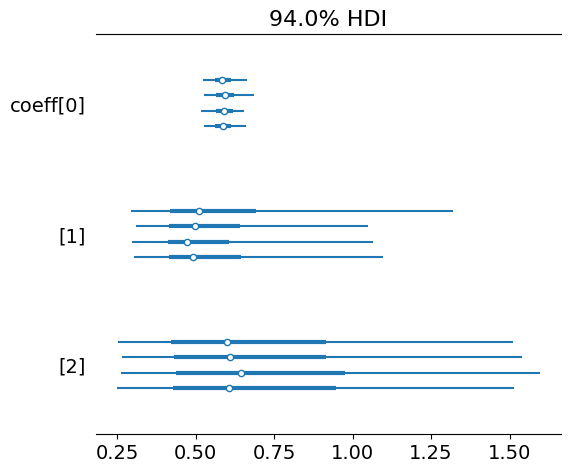

In [138]:
az.plot_forest(idata_pymc,var_names=["alpha","lam"])
az.plot_forest(idata_pymc,var_names=["coeff"])

Output()

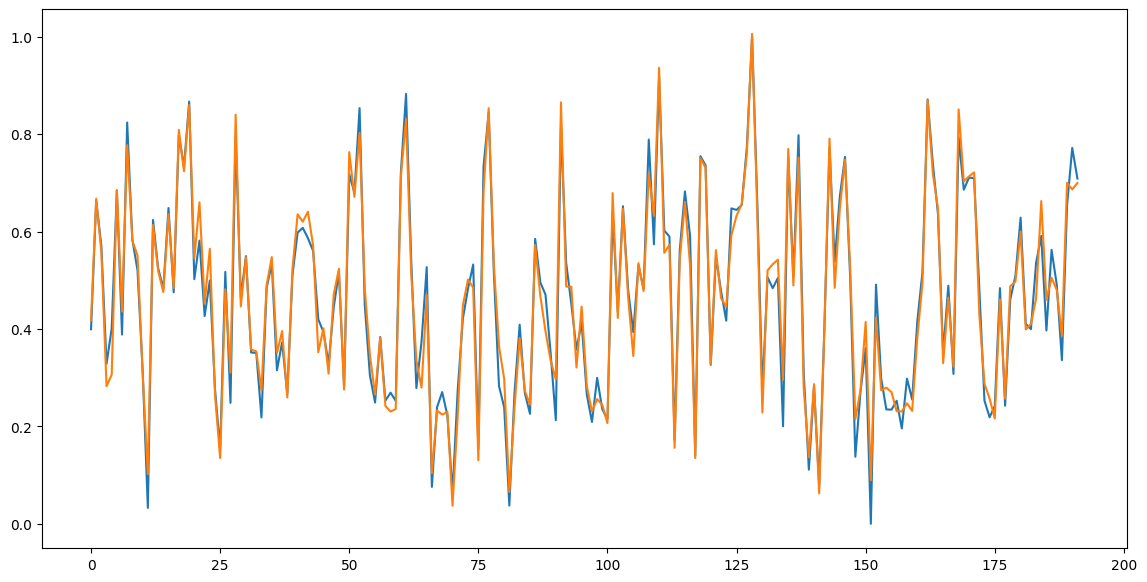

In [140]:
with pymc_model:
    train_pps = pm.sample_posterior_predictive(idata_pymc,var_names=["mu"])

mu_pps = train_pps.posterior_predictive["mu"].mean(dim=["chain","draw"])

plt.figure(figsize=(14,7))
plt.plot( Y_data.iloc[train_idx].values,'-',label='Actual')
plt.plot(mu_pps.values,'-',label="Predictive")
plt.show()

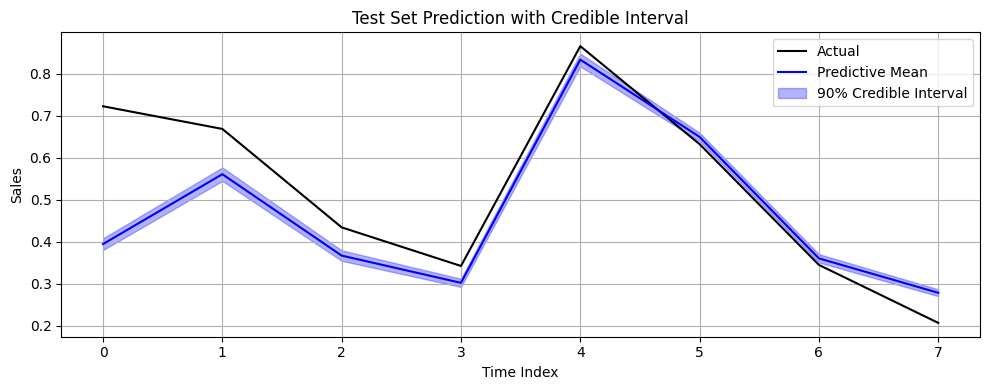

In [122]:
mu_test_dist = posterior_predictive_test.posterior_predictive["mu"]
mu_test_mean = mu_test_dist.mean(dim=["chain", "draw"]).values
mu_test_hpd = np.percentile(mu_test_dist.values, [5, 95], axis=(0, 1))  # 90% credible interval

# Plot
plt.figure(figsize=(10, 4))
plt.plot(Y_data.iloc[test_idx].values, '-', label='Actual', color='black')
plt.plot(mu_test_mean, '-', label='Predictive Mean', color='blue')
plt.fill_between(
    x=np.arange(len(mu_test_mean)),
    y1=mu_test_hpd[0],
    y2=mu_test_hpd[1],
    color='blue',
    alpha=0.3,
    label='90% Credible Interval'
)
plt.legend()
plt.xlabel("Time Index")
plt.ylabel("Sales")
plt.title("Test Set Prediction with Credible Interval")
plt.grid(True)
plt.tight_layout()
plt.show()

In the above model, we have taken account of seasonal effects on the sales. It is a more involved methodology.
Pymc already added all these effects in their pymc_marketing package. 

### Using pymc_marketing

In [217]:
mmm_default = MMM(
    adstock=GeometricAdstock(l_max=8),
    saturation=LogisticSaturation(),
    date_column="Date",
    channel_columns=media_columns,
    model_config={
        'saturation_lam':Prior("Gamma",alpha=2,beta=0.5,dims="channel")
    }
)

mmm_default.default_model_config

{'intercept': Prior("Normal", mu=0, sigma=2),
 'likelihood': Prior("Normal", sigma=Prior("HalfNormal", sigma=2)),
 'gamma_control': Prior("Normal", mu=0, sigma=2, dims="control"),
 'gamma_fourier': Prior("Laplace", mu=0, b=1, dims="fourier_mode"),
 'adstock_alpha': Prior("Beta", alpha=1, beta=3, dims="channel"),
 'saturation_lam': Prior("Gamma", alpha=2, beta=0.5, dims="channel"),
 'saturation_beta': Prior("HalfNormal", sigma=2, dims="channel")}

In [218]:
fit_kwargs = {
    "tune": 1000,
    "chains":4,
    "draw":1000,
    "target_accept":0.9
}
X_data = data_scaled[media_columns]
X_data['Date']=data['Date']

mmm_default.fit(X_data[train_idx],Y_data[train_idx],**fit_kwargs)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, adstock_alpha, saturation_lam, saturation_beta, y_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 343 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data
	> fit_data

Output()

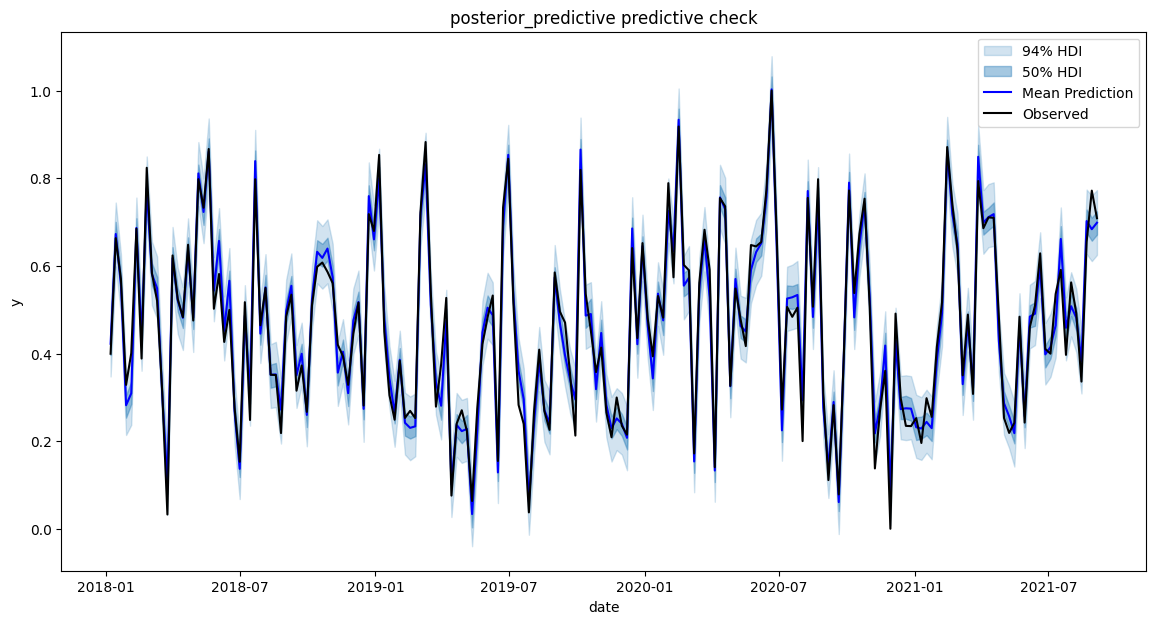

In [219]:
mmm_default.sample_posterior_predictive(X_data[train_idx], extend_idata=True, combined=True)

mmm_default.plot_posterior_predictive(original_scale=True,figsize=(14,7));

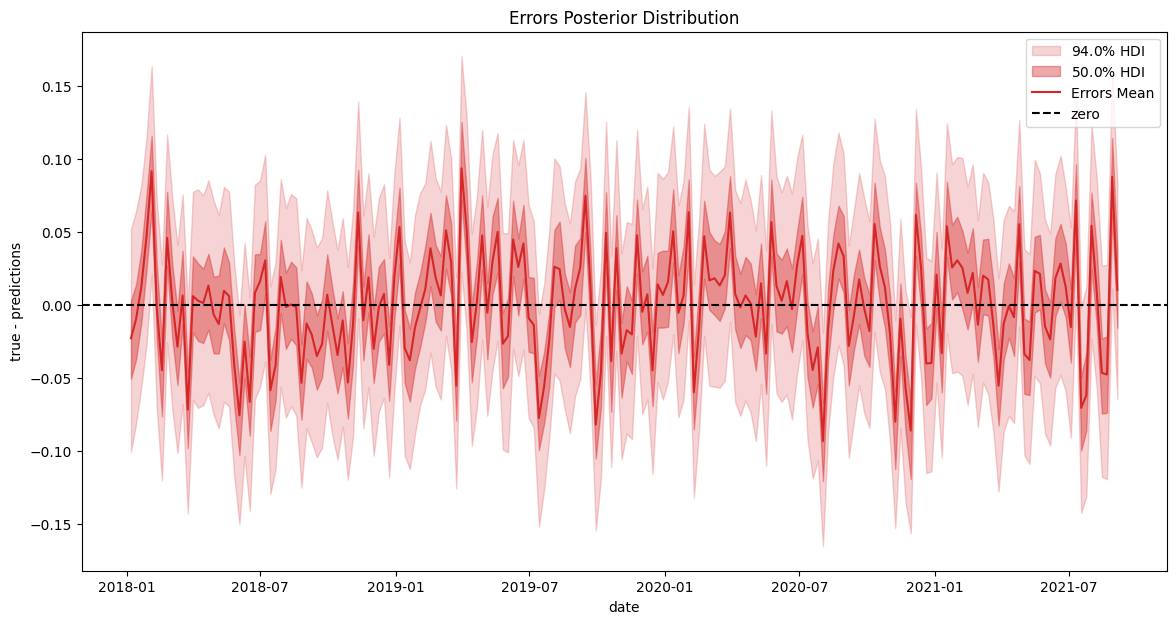

In [220]:
mmm_default.plot_errors(figsize=(14,7));

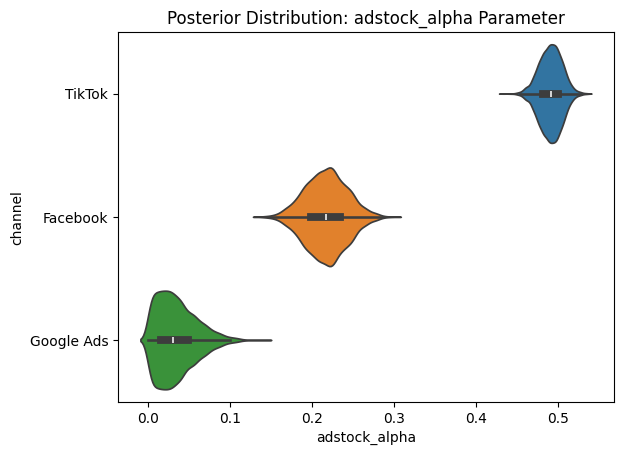

In [221]:
fig= mmm_default.plot_channel_parameter(param_name='adstock_alpha')

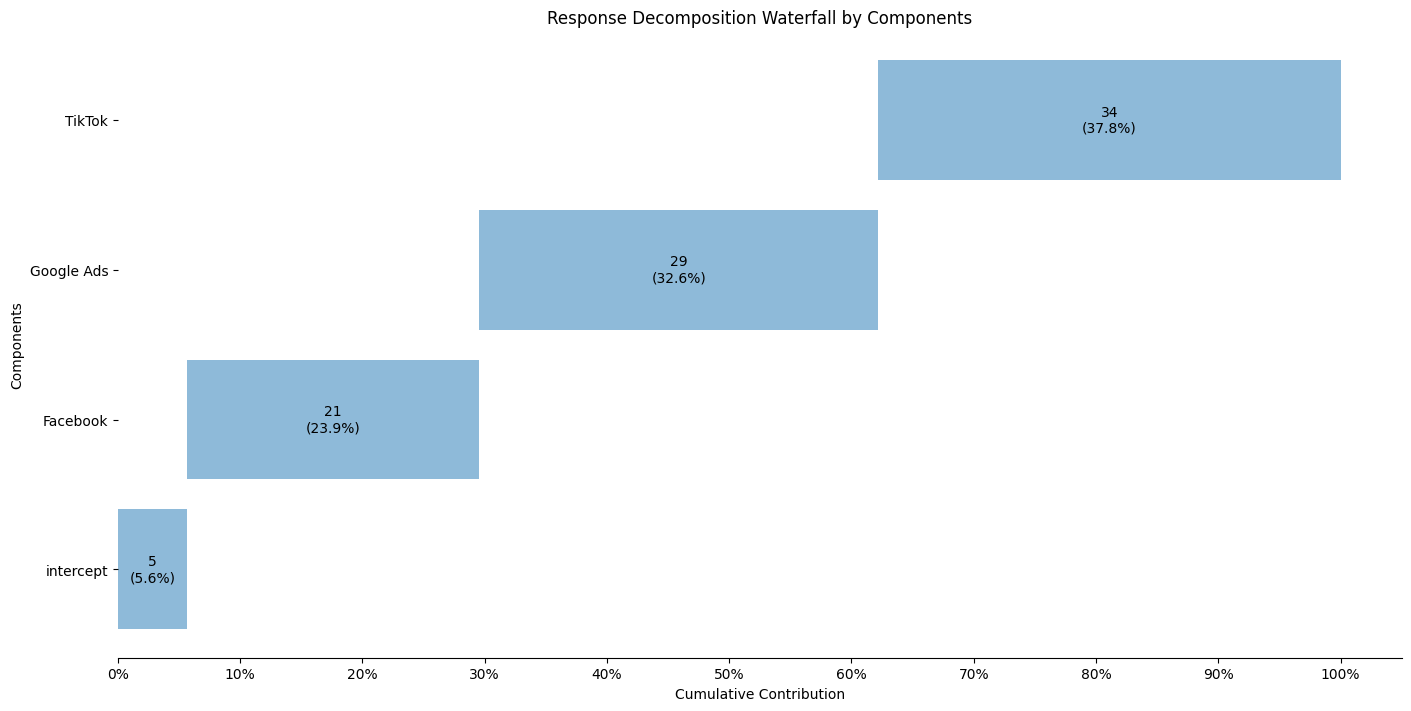

In [222]:
mmm_default.plot_waterfall_components_decomposition();

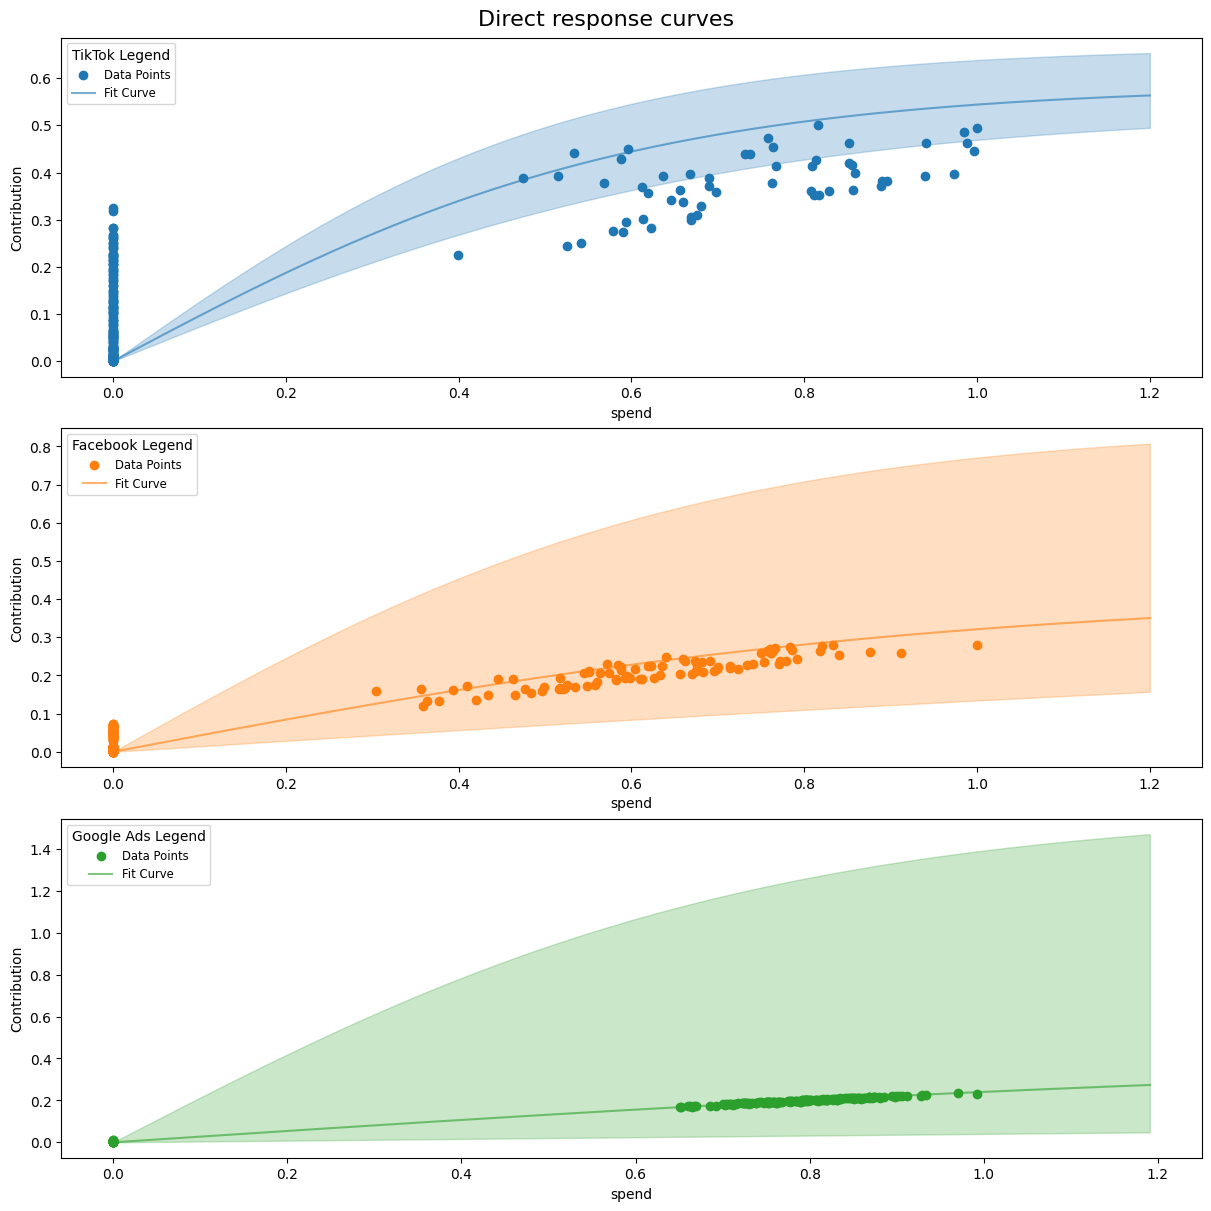

In [223]:
fig = mmm_default.plot_direct_contribution_curves(show_fit=True, xlim_max=1.2)
[ax.set(xlabel="spend") for ax in fig.axes];

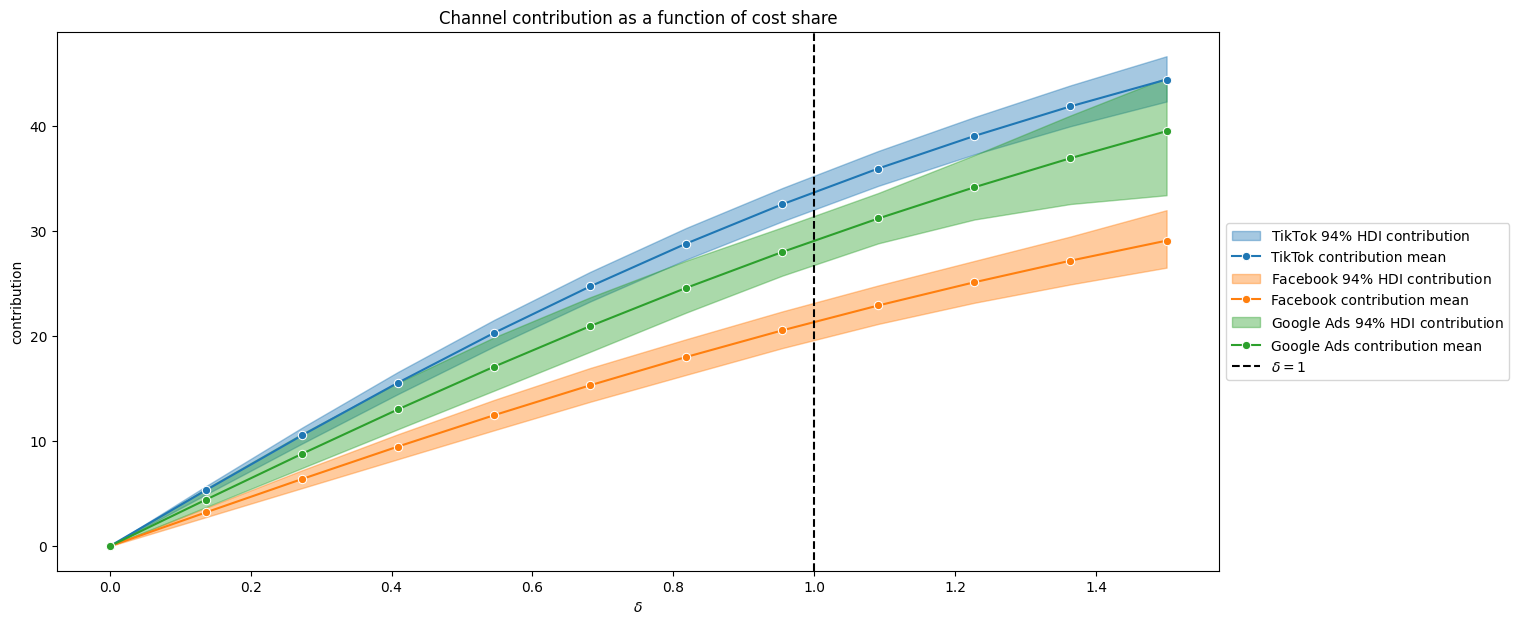

In [224]:
mmm_default.plot_channel_contribution_grid(start=0, stop=1.5, num=12, figsize=(15, 7));

### Budget optimization

In [225]:
perc_change =0.2
budget_len =30
budget_idx = slice(len(data)-budget_len,len(data))

recent_period = data[budget_idx][media_columns]
recent_period

,TikTok,Facebook,Google Ads
170,11841.72,0.00,1951.73
171,0.00,6742.67,1824.36
172,0.00,0.00,2139.88
173,0.00,0.00,1787.76
174,0.00,0.00,1955.50
175,0.00,4111.03,0.00
176,0.00,5242.12,2010.19
177,0.00,0.00,1641.15
178,0.00,5936.74,2265.29
179,0.00,6412.33,1807.08


In [226]:
budget = 10000#round(recent_period.sum(axis=0).sum()/budget_len , -3)

current_budget_split = round(recent_period.mean()/recent_period.mean().sum(),2)

lower_bound = round(recent_period.min(axis=0)*(1-perc_change),2)
upper_bound = round(recent_period.max(axis=0)*(1+perc_change),2)

budget_bounds = {col : [lower_bound[col],upper_bound[col]]
                 for col in media_columns}

print(f'Overall budget constraint: {budget}')
print('Channel constraints:')
for channel, bounds in budget_bounds.items():
    print(f'  {channel}: Lower Bound = {bounds[0]}, Upper Bound = {bounds[1]}')

Overall budget constraint: 10000
Channel constraints:
  TikTok: Lower Bound = 0.0, Upper Bound = 15703.24
  Facebook: Lower Bound = 0.0, Upper Bound = 8091.2
  Google Ads: Lower Bound = 0.0, Upper Bound = 3022.66


In [227]:
model_granularity = "weekly"

allocation_strategy, optimization_result = mmm_default.optimize_budget(
    budget=budget,
    budget_bounds=budget_bounds,
    num_periods=budget_len,
    minimize_kwargs={
        "method":"SLSQP",
        "options":{"ftol":1e-09,"maxiter":5_000},
    }
)

response = mmm_default.sample_response_distribution(
    allocation_strategy=allocation_strategy,
    time_granularity = model_granularity,
    num_periods=budget_len,
    noise_level=0.05
)


/usr/local/anaconda3/envs/datascience/lib/python3.10/site-packages/pymc_marketing/mmm/budget_optimizer.py:227: UserWarning: Using default equality constraint
  self.set_constraints(


In [228]:
opt_spend = pd.Series(allocation_strategy, index=recent_period.mean().index).to_frame(name="opt_spend")
opt_spend["avg_spend"] = budget * current_budget_split
opt_spend

,opt_spend,avg_spend
TikTok,518.839642,4600.0
Facebook,6458.500358,2800.0
Google Ads,3022.660000,2500.0


In [229]:
opt_spend.sum()

opt_spend    10000.0
avg_spend     9900.0
dtype: float64

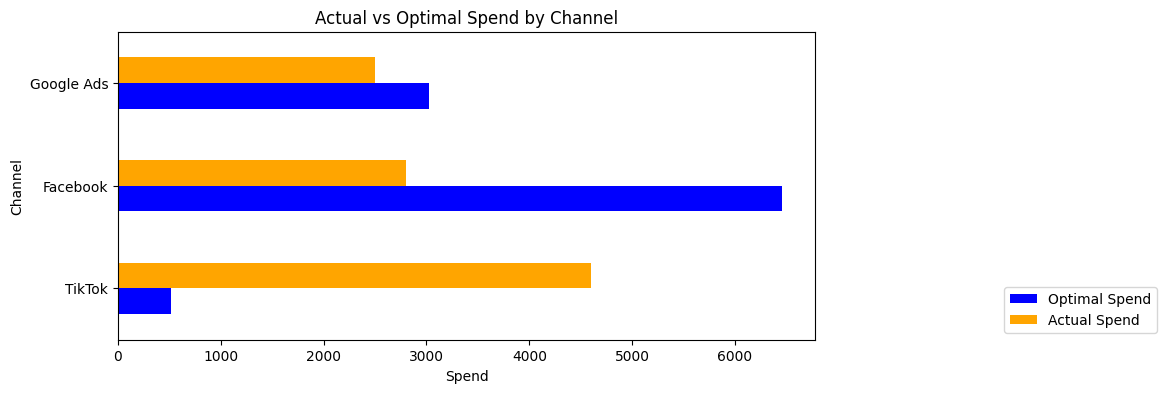

In [230]:
fig, ax = plt.subplots(figsize=(9, 4))
opt_spend.plot(kind='barh', ax=ax, color=['blue', 'orange'])

plt.xlabel("Spend")
plt.ylabel("Channel")
plt.title("Actual vs Optimal Spend by Channel")
plt.legend(["Optimal Spend", "Actual Spend"])
plt.legend(["Optimal Spend", "Actual Spend"], loc='lower right', bbox_to_anchor=(1.5, 0.0))

plt.show()

In [189]:
mmm_default.X['Date']

0     2018-01-07
1     2018-01-14
2     2018-01-21
3     2018-01-28
4     2018-02-04
         ...    
187   2021-08-08
188   2021-08-15
189   2021-08-22
190   2021-08-29
191   2021-09-05
Name: Date, Length: 192, dtype: datetime64[ns]

In [231]:
# create dataframe with optimal spend
last_date = mmm_default.X['Date'].max()
new_dates = pd.date_range(start=last_date, periods=1 + budget_len, freq="W-MON")[1:]
budget_scenario_opt = pd.DataFrame({"Date": new_dates,})
budget_scenario_opt["TikTok"] = opt_spend["opt_spend"]["TikTok"]
budget_scenario_opt["Facebook"] = opt_spend["opt_spend"]["Facebook"]
budget_scenario_opt["Google Ads"] = opt_spend["opt_spend"]["Google Ads"]
# budget_scenario_opt["demand"] = X[budget_idx][control_cols].mean()[0]

# calculate overall contribution
scenario_contrib_opt = mmm_default.sample_posterior_predictive(
    X_pred=budget_scenario_opt, extend_idata=False
)

opt_contrib = scenario_contrib_opt.mean(dim="sample").sum()["y"].values


Output()

In [232]:
# create dataframe with avg spend
last_date = mmm_default.X["Date"].max()
new_dates = pd.date_range(start=last_date, periods=1 + budget_len, freq="W-MON")[1:]
budget_scenario_avg = pd.DataFrame({"Date": new_dates,})
budget_scenario_avg["TikTok"] = opt_spend["avg_spend"]["TikTok"]
budget_scenario_avg["Facebook"] = opt_spend["avg_spend"]["Facebook"]
budget_scenario_avg["Google Ads"] = opt_spend["avg_spend"]["Google Ads"]
# budget_scenario_avg["demand"] = X[budget_idx][control_cols].mean()[0]

# calculate overall contribution
scenario_contrib_avg  = mmm_default.sample_posterior_predictive(
    X_pred=budget_scenario_avg , extend_idata=False
)

avg_contrib = scenario_contrib_avg.mean(dim="sample").sum()["y"].values

Output()

In [233]:
print(f'% increase in sales: {round((opt_contrib / avg_contrib) - 1, 2)}')

% increase in sales: -0.0


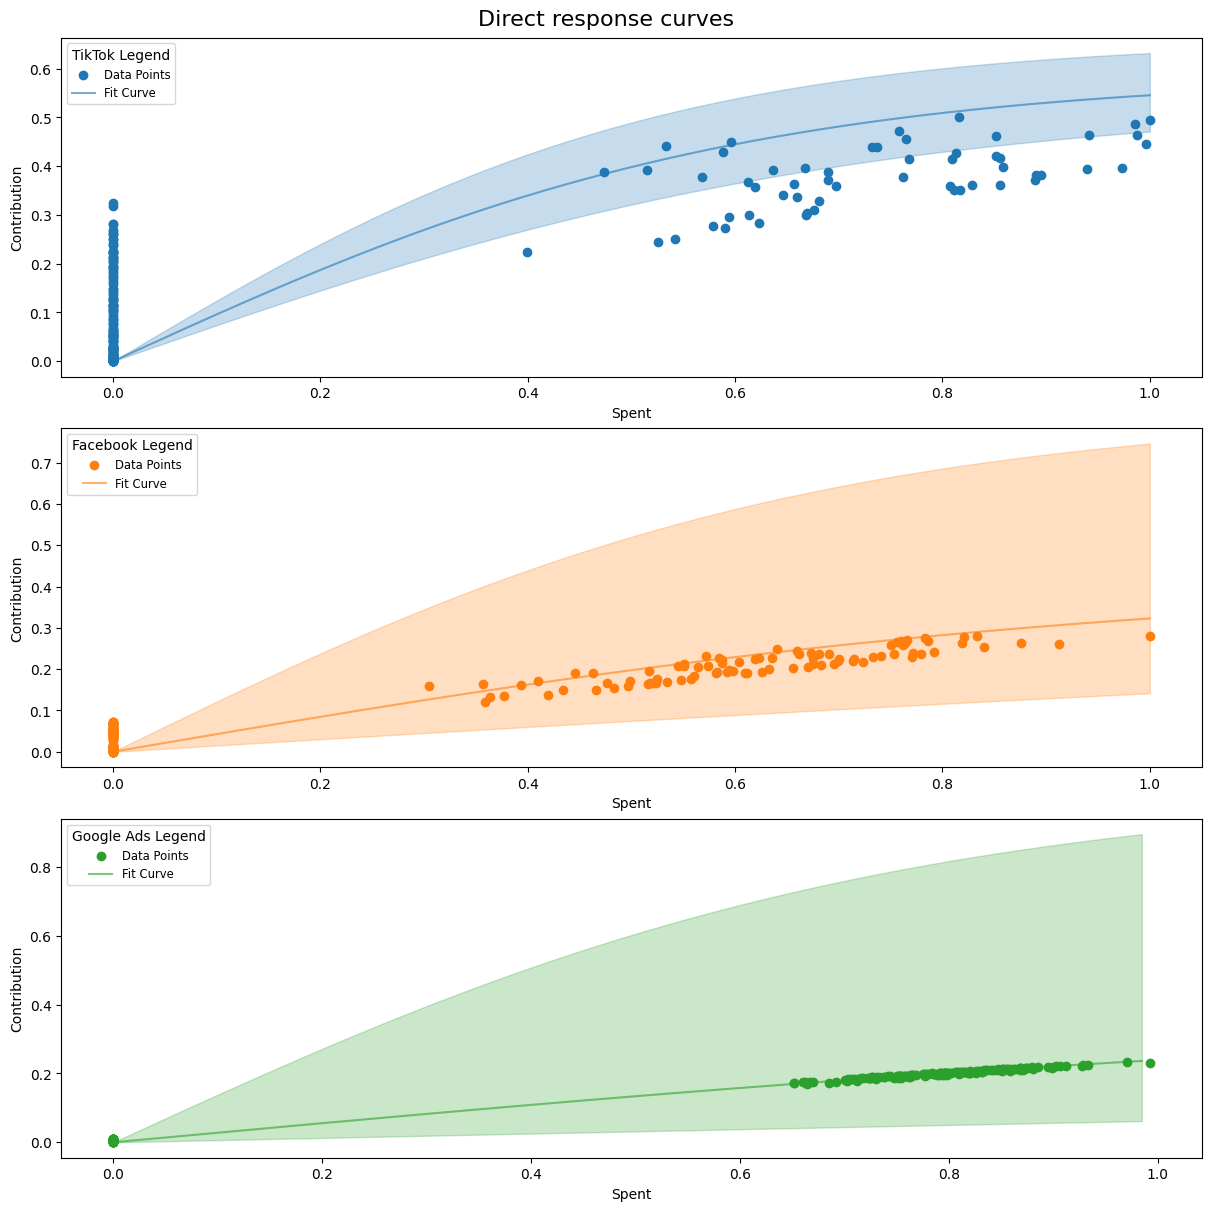

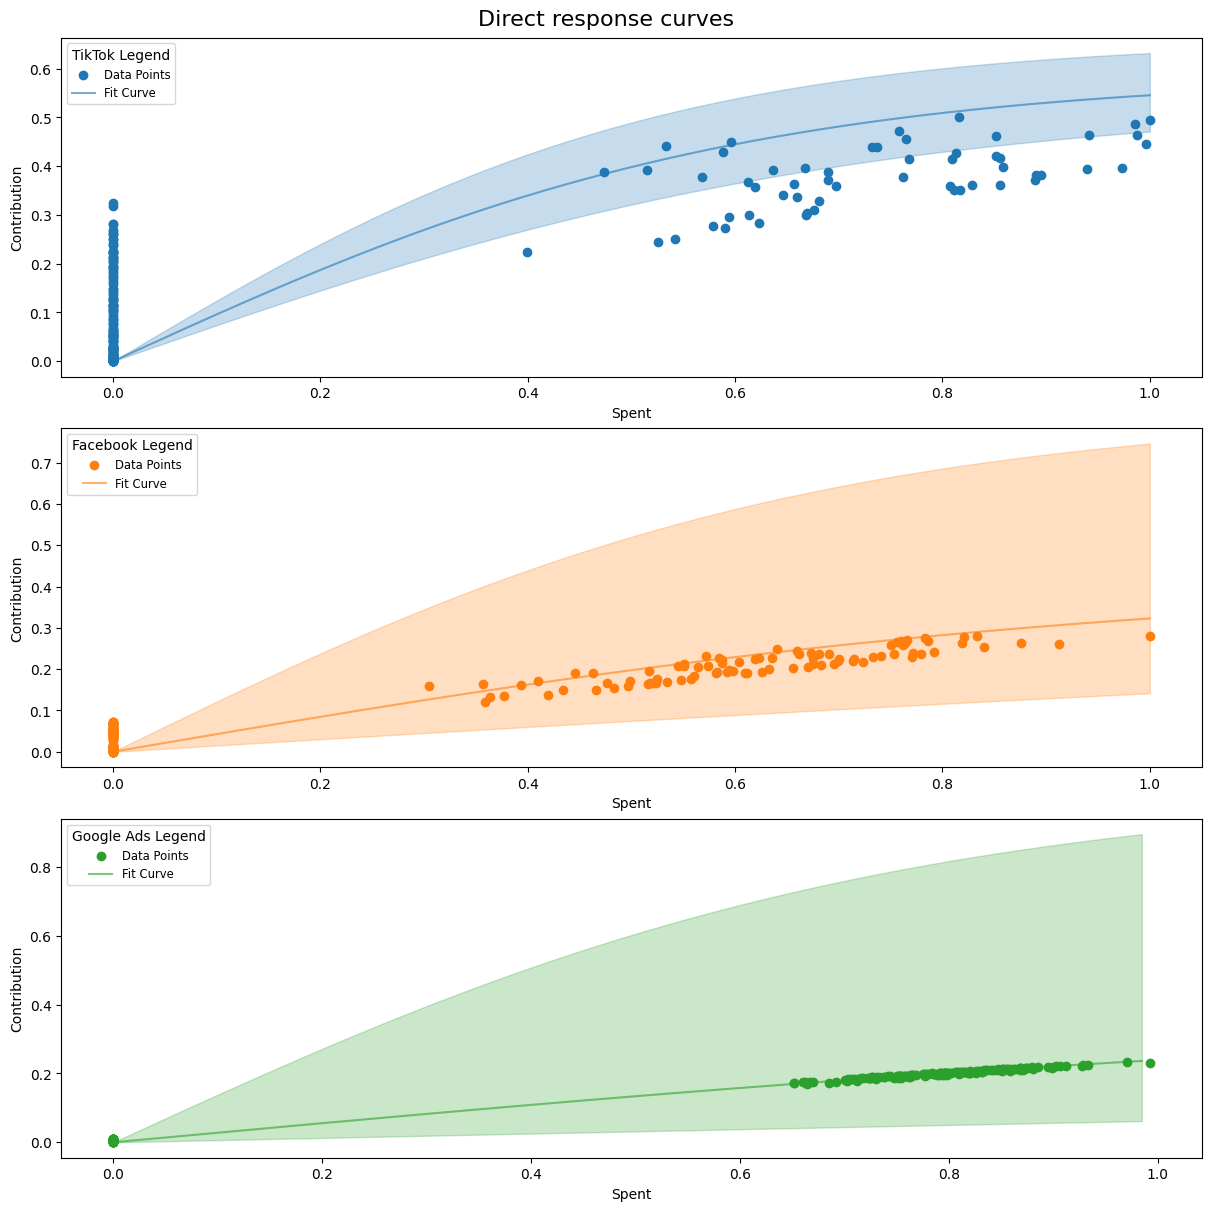

In [200]:
mmm_default.plot_direct_contribution_curves(show_fit=True)